In [1]:
import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [2]:
NC_backbone = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/G_mother.graphml")

In [3]:
# remove all nodes with length of lyrics less than 50
count = 0

for node in list(NC_backbone.nodes):
    text = NC_backbone.nodes[node].get('lyrics','')
    if len(text) < 50:
        NC_backbone.remove_node(node)
        count += 1

print(f"Removed {count} nodes with lyrics length less than 50.")

Removed 21 nodes with lyrics length less than 50.


In [4]:
# find all cliques in the backbone
cliques = list(nx.find_cliques(NC_backbone))
print(f"Number of cliques in the backbone: {len(cliques)}")

# print the largest clique
largest_clique = max(cliques, key=len)
print(f"Largest clique size: {len(largest_clique)}")
print(f"Largest clique members: {largest_clique}")

# analyze clique size distribution
clique_sizes = [len(clique) for clique in cliques]
size_counts = pd.Series(clique_sizes).value_counts().sort_index()
print("Clique size distribution:")
print(size_counts)

Number of cliques in the backbone: 16577
Largest clique size: 9
Largest clique members: ['Joe_Nichols', 'Jason_Aldean', 'Blake_Shelton', 'Cole_Swindell', 'Alan_Jackson', 'Trace_Adkins', 'Little_Big_Town', 'Randy_Travis', 'Kenny_Chesney']
Clique size distribution:
1       1
2     317
3    3542
4    6110
5    3958
6    1816
7     666
8     157
9      10
Name: count, dtype: int64


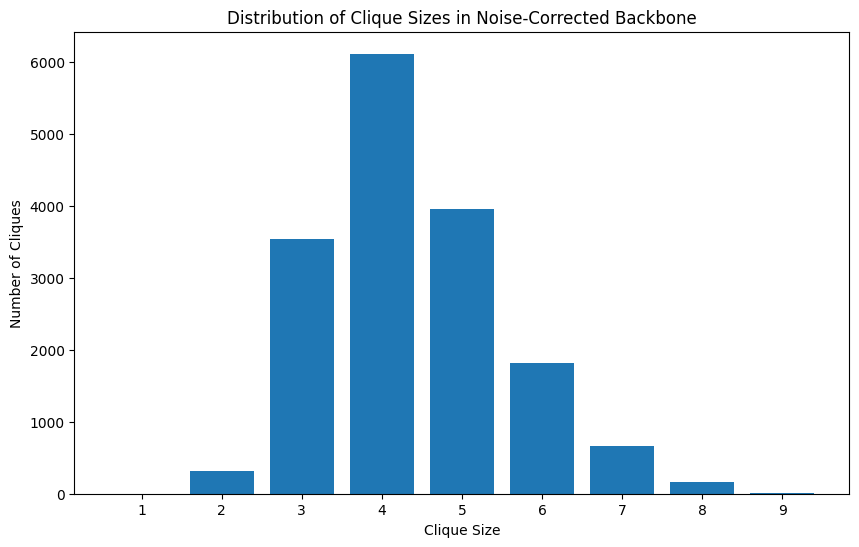

In [27]:
# plot the distribution of clique sizes
plt.figure(figsize=(10, 6))
plt.bar(size_counts.index, size_counts.values)
plt.xlabel('Clique Size')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Clique Sizes in Noise-Corrected Backbone')
plt.xticks(size_counts.index)
plt.show()

Above the clique distribution of the network is plotted.
Most frequent clique size is 4, with over 6,000 cliques.Clique sizes of 3 and 5 are also common, indicating moderate-sized fully connected groups. Larger cliques (sizes 7–9) are rare, suggesting that dense subgroups of many artists are uncommon. Very few cliques of size 2 (pairs).

The backbone preserves local dense structures, which are likely meaningful clusters of artists frequently co-occurring on playlists. The absence of very large cliques suggests that the backbone reduces hub-driven connectivity and focuses on cohesive subgroups rather than global hubs. Which we also saw when plotting the degree distribution of the original graph and NC backbone earlier.
This pattern supports the idea that the Noise-Corrected Backbone enhances modularity and community detection potential.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


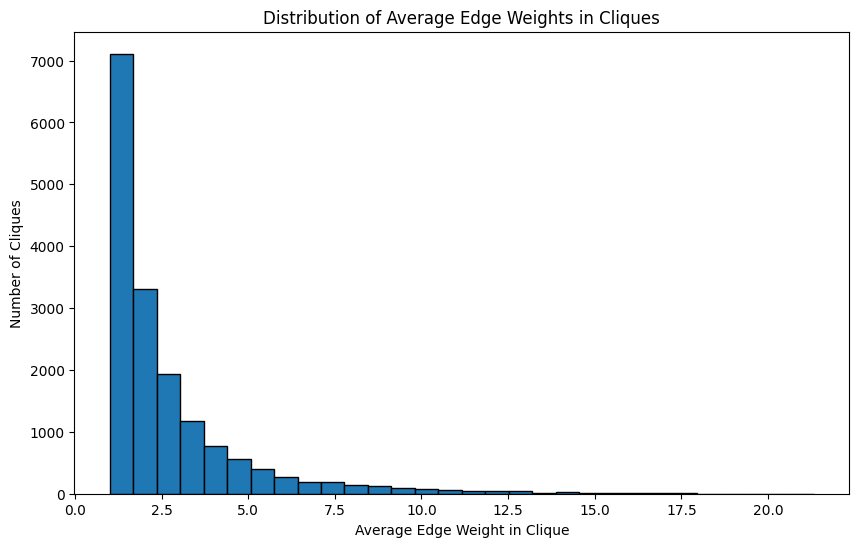

Highest average edge weight in a clique: 21.333333333333332


In [5]:
# Distribution of averge weights of edges in cliques
average_weights = []
for clique in cliques:
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    average_weights.append(average_weight)

plt.figure(figsize=(10, 6))
plt.hist(average_weights, bins=30, edgecolor='black')
plt.xlabel('Average Edge Weight in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Average Edge Weights in Cliques')
plt.show()

print("Highest average edge weight in a clique:", max(average_weights))

The above plot shows the distribution of average edge weights in cliques found in the noise-corrected backbone.

The distribution is highly skewed toward low values. Most cliques have an average edge weight between 1.0 and 2.5, with the highest frequency around 1.5. A long tail extends up to 21.33, but very few cliques have such high average weights.

Cliques with higher average weights represent strongly interconnected artist groups (e.g., frequent co-occurrence across playlists). These heavily connected artists would be interesting for further analysis.

The dominance of low-weight cliques indicates that meaningful communities can emerge from moderate-weight ties when they are statistically significant.


We will in further analysis only consider cliques of size above a certain threshold.

In [8]:
# filter out cliques with size above 4
filtered_cliques = []
threshold = 4
for clique in cliques:
    if len(clique) > threshold:
        filtered_cliques.append(clique)
print(f"Number of cliques with size greater than {threshold}: {len(filtered_cliques)}")

Number of cliques with size greater than 4: 6607


We will filter out the "strong" cliques, which are the cliques that has an average edge weight above a certain threshold.

In [9]:
# Filter out cliques with average edge weight above a threshold
threshold = 15  # example threshold
strong_cliques = []
for clique in cliques:
    if len(clique) < 4:
        continue  # skip cliques with less than 3 nodes
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    if average_weight >= threshold:
        strong_cliques.append(clique)

print(f"Number of cliques with average edge weight >= {threshold}: {len(strong_cliques)}")


Number of cliques with average edge weight >= 15: 32


Only 35 cliques are extremely strong artist communities, where every pair of artists co-occurs on playlists with very high frequency.
We suspect that these extremely connected/strong artist communities contain highly popular artists (e.g., artists who frequently appear together in curated playlists). The below code prints the 5 strongest cliques and we see that these are all top-tier artists. Furthermore, these artists are all associated with hip-hop/R&B and some pop, suggesting genre-specific clusters with strong playlist co-occurrence.

The rarity of these cliques emphasizes that most communities in the backbone are formed by moderate-weight edges that are statistically significant rather than extremely heavy.

In [10]:
# top 5 strong cliques by average edge weight
clique_weights = []
for clique in strong_cliques:
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    clique_weights.append((clique, average_weight))
    clique_weights.sort(key=lambda x: x[1], reverse=True)

print("Top 5 strong cliques by average edge weight:")
for clique, weight in clique_weights[:5]:
    print(clique)
    print(f"Average edge weight: {weight}")

Top 5 strong cliques by average edge weight:
['The_Weeknd', 'Rihanna', 'Chris_Brown', 'Miley_Cyrus']
Average edge weight: 21.333333333333332
['The_Weeknd', 'Drake', 'Chris_Brown', 'Russ']
Average edge weight: 20.833333333333332
['The_Weeknd', 'Drake', 'Chris_Brown', 'Rae_Sremmurd', 'Wiz_Khalifa', 'Kendrick_Lamar']
Average edge weight: 20.4
['The_Weeknd', 'Sia', 'Rihanna', 'Miley_Cyrus']
Average edge weight: 19.666666666666668
['The_Weeknd', 'Drake', 'Chris_Brown', 'Miguel', 'Kendrick_Lamar']
Average edge weight: 19.1


#### Sentiment i cliques

We want to investigate if there are any similarity in sentiment score for the aritists in the cliques. Below the mean sentiment and standard deviation is calculated for each clique. The top 5 most positive and top 5 most negative cliques are printed. 

In [ ]:
# Top 5 cliques by sentiment score mean
top_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in x]), reverse=True)[:5]
print("Top 5 cliques by sentiment score mean:")
for clique in top_5_mean_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    print("\n")

# bottom 5 cliques by sentiment score mean
bottom_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in x]))[:5]
print("Bottom 5 cliques by sentiment score mean:")
for clique in bottom_5_mean_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    print("\n")

Top 5 cliques by sentiment score mean:
Clique size: 5, Mean sentiment: 1.0, Standard deviation: 0.0
['Trey_Songz', 'Chris_Brown', 'Ne-Yo', 'Rihanna', 'Jason_Derulo']


Clique size: 5, Mean sentiment: 1.0, Standard deviation: 0.0
['Queen', 'Chris_Brown', 'Britney_Spears', 'Justin_Bieber', 'Jason_Derulo']


Clique size: 5, Mean sentiment: 1.0, Standard deviation: 0.0
['Britney_Spears', 'Jason_Derulo', 'Meghan_Trainor', 'Justin_Bieber', 'Lady_Gaga']


Clique size: 6, Mean sentiment: 0.9999833333333333, Standard deviation: 3.726779962499239e-05
['Rihanna', 'Pitbull', 'Chris_Brown', 'Britney_Spears', 'Jason_Derulo', 'Ne-Yo']


Clique size: 6, Mean sentiment: 0.9999833333333333, Standard deviation: 3.726779962499239e-05
['Rihanna', 'Pitbull', 'Chris_Brown', 'Britney_Spears', 'Jason_Derulo', 'Miley_Cyrus']


Bottom 5 cliques by sentiment score mean:
Clique size: 5, Mean sentiment: -0.9998400000000001, Standard deviation: 0.00016248076809270132
['Juicy_J', 'Yo_Gotti', 'Big_Sean', 'Kevin_Gates'

This show, that there are cliques, that have mean sentiment ≈ +1 and standard deviation ≈ 0, meaning that the artists of the cliques share a strongly positive sentiment score.

Furthermore, there are cliques, that have mean sentiment ≈ -1 and very low standard deviation, meaning the artists share strongly negative sentiment scores.

To further investigate the sentiment of the cliques, a Histogram of standard deviations is made, showing the distribution.

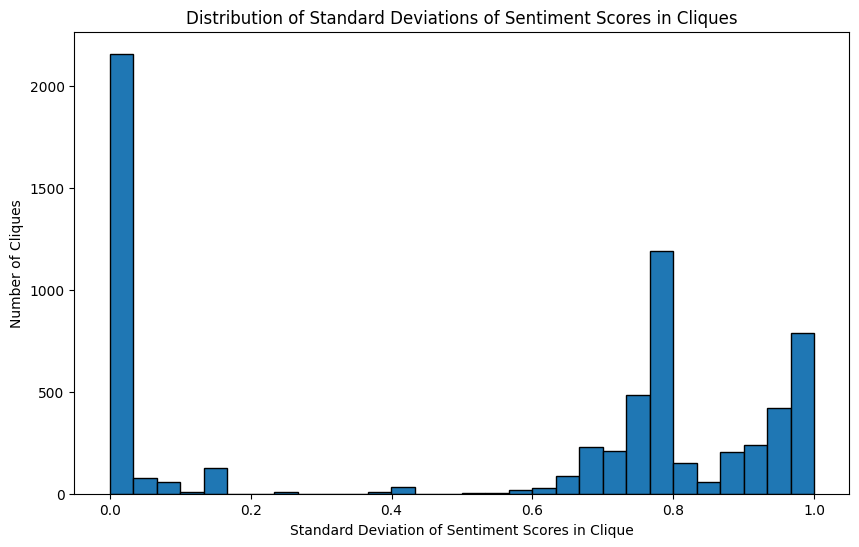

In [13]:
# histogram of distribution of standard deviations of sentiment scores in cliques
std_devs = []
for clique in filtered_cliques:
    sentiments = [NC_backbone.nodes[node].get('sentiment_compound') for node in clique]
    std_dev = np.std(sentiments)
    std_devs.append(std_dev)
plt.figure(figsize=(10, 6))
plt.hist(std_devs, bins=30, edgecolor='black')
plt.xlabel('Standard Deviation of Sentiment Scores in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Standard Deviations of Sentiment Scores in Cliques')
plt.show()


The plot above shows:

Large spike at 0: Over 2,000 cliques have a standard deviation near zero, meaning all members share very similar sentiment scores (high internal homogeneity).

Sparse middle range (0.2–0.6): Few cliques exhibit moderate variability in sentiment.

Secondary cluster near 0.8–1.0: Many cliques have very high variability, suggesting strong disagreement or mixed sentiment among members.

Hereby we see that the network has two dominant clique types, Highly homogeneous cliques (low variability) and highly heterogeneous cliques (high variability). Very few cliques fall in the middle, indicating polarization or strong thematic grouping.

#### Lyrical similarity (semantics from embedding) in cliques

In [15]:
# load graphml file
NC_backbone = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/G_mother.graphml")

In [16]:
import networkx as nx
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

G = NC_backbone

Below the average cosine similarity between all pairs of nodes in all cliques are calculated. We want to investigate, if there are lyrical similarity in the cliques.

In [ ]:
# calculate the average cosine similarity between all pairs of nodes in cliques based on 'lyric_vector' attribute
from itertools import combinations

average_cosine_sims_of_cliques = []

for clique in filtered_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    if len(vectors) < 2:
        continue  # skip cliques with less than 2 vectors
    cosine_sims = []
    for vec1, vec2 in combinations(vectors, 2):
        sim = cosine_similarity([vec1], [vec2]) 
        cosine_sims.append(sim)
    average_cosine_sim = np.mean(cosine_sims)
    average_cosine_sims_of_cliques.append(average_cosine_sim)




We plot the distribution of cosine similarities in cliques.

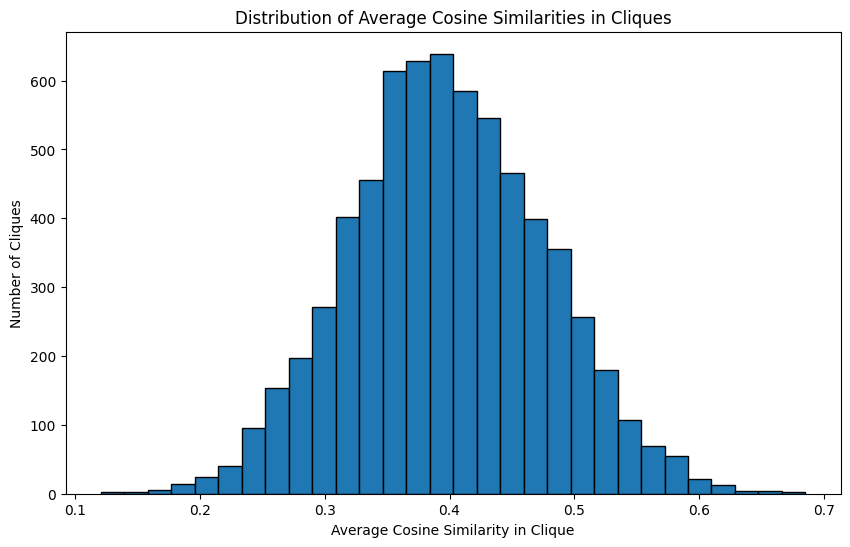

In [19]:
# plot the distributon of average cosine similarities and 

plt.figure(figsize=(10, 6))
plt.hist(average_cosine_sims_of_cliques, bins=30, edgecolor='black')
plt.xlabel('Average Cosine Similarity in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Average Cosine Similarities in Cliques')
plt.show()


This histogram shows the distribution of average cosine similarity within cliques.

The distribution is roughly bell-shaped, centered around 0.35–0.4. Most cliques have moderate similarity (0.3–0.5), suggesting members share some common features but are not identical.
Very few cliques have extremely low (<0.2) or high (>0.6) similarity, meaning highly dissimilar or highly homogeneous cliques are rare.

Unlike the previous sentiment standard deviation plot (which showed polarization), this suggests cliques are generally cohesive but not overly homogeneous.
The peak near 0.4 indicates moderate lyrical simiilarity among artists in playlists.

Below the most similar cliques in terms of cosine similarity are printed.

In [22]:
top_30_cosine_cliques = sorted(filtered_cliques, key=lambda clique: np.mean([
    cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
    for node1, node2 in combinations(clique, 2)]), reverse=True)[:30]

print("Top 30 cliques by average cosine similarity:")
for clique in top_30_cosine_cliques:
    mean = np.mean([cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
                       for node1, node2 in combinations(clique, 2)])
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {mean}")
    print(clique)
    print("\n")

Top 30 cliques by average cosine similarity:
Clique size: 5, Average Cosine Similarity: 0.6849303782806868
['J_Balvin', 'Luis_Fonsi', 'Ozuna', 'Maluma', 'Reik']


Clique size: 5, Average Cosine Similarity: 0.6678001029685126
['J_Balvin', 'Noriel', 'Ozuna', 'Yandel', 'Maluma']


Clique size: 5, Average Cosine Similarity: 0.6584612055605039
['J_Balvin', 'Pepe_Quintana', 'Yandel', 'Noriel', 'Maluma']


Clique size: 5, Average Cosine Similarity: 0.6545586005505684
['Big_Sean', 'Yo_Gotti', 'Meek_Mill', 'Mike_Stud', 'Tyga']


Clique size: 5, Average Cosine Similarity: 0.6518538816226757
['Fetty_Wap', 'Future', 'Snoop_Dogg', 'The_Game', 'Mike_WiLL_Made-It']


Clique size: 5, Average Cosine Similarity: 0.6518119472688789
['Ozuna', 'Reik', 'Farruko', 'Maluma', 'Bad_Bunny']


Clique size: 5, Average Cosine Similarity: 0.6424340707137988
['Fetty_Wap', 'JAY_Z', 'Future', 'The_Game', 'Snoop_Dogg']


Clique size: 5, Average Cosine Similarity: 0.6409796255370793
['ScHoolboy_Q', 'Meek_Mill', 'Lil_Wayn

In the top 20 cliques on cosine similarity, there are two dominant stylistic families.
Latin urban/reggaeton and Mainstream US hip‑hop. 
